In [1]:
import time

import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score

from modules.device import best_device
from modules.transformer import TransformerConfig, TransformerClassifier
from modules.training import train_classifier
from modules.visualization import plot_history

In [ ]:
device = best_device()
print(f"Using device: {device}")

# Config - Optimized based on Optuna results
BATCH_SIZE = 32
MAX_SEQ_LEN = 256
NUM_EPOCHS_SCRATCH = 20
NUM_EPOCHS_FT = 5
LR_SCRATCH = 1e-4
LR_FT = 1e-4

# Regularization & Optimization
WEIGHT_DECAY = 0.0015
WARMUP_RATIO = 0.06
MAX_GRAD_NORM = 1.7
PATIENCE = 4

Using device: cuda


In [3]:
# Load Polish Youth Slang Dataset
dataset = load_dataset("jziebura/polish_youth_slang_classification")

# Tokenizer (Polish GPT-2)
tokenizer_name = "sdadas/polish-gpt2-small"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Fix padding token if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Rename columns to match standard format
if "tekst" in dataset["train"].column_names: # type: ignore
    dataset = dataset.rename_column("tekst", "text")
if "sentyment" in dataset["train"].column_names: # type: ignore
    dataset = dataset.rename_column("sentyment", "labels")

# Create Train/Val/Test splits (80/10/10)
# The dataset only has 'train'.
# First split: 80% Train, 20% Temp (Val+Test)
split_1 = dataset["train"].train_test_split(test_size=0.2, seed=42) # type: ignore
train_dataset_raw = split_1["train"]
test_val_dataset = split_1["test"]

# Second split: Split Temp into 50% Val, 50% Test (which is 10% of total each)
split_2 = test_val_dataset.train_test_split(test_size=0.5, seed=42)
val_dataset_raw = split_2["train"]
test_dataset_raw = split_2["test"]

print(f"Split sizes: Train={len(train_dataset_raw)}, Val={len(val_dataset_raw)}, Test={len(test_dataset_raw)}")

# Verify Class Distribution
print("\nClass Distribution (Train):")
print(np.unique(train_dataset_raw["labels"], return_counts=True))

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_SEQ_LEN)

# Tokenize
train_dataset = train_dataset_raw.map(tokenize_function, batched=True)
val_dataset = val_dataset_raw.map(tokenize_function, batched=True)
test_dataset = test_dataset_raw.map(tokenize_function, batched=True)

# Keep only necessary columns & format
cols = ["input_ids", "attention_mask", "labels"]
train_dataset = train_dataset.select_columns(cols)
val_dataset = val_dataset.select_columns(cols)
test_dataset = test_dataset.select_columns(cols)

train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Split sizes: Train=3469, Val=434, Test=434

Class Distribution (Train):
(array([0, 1, 2]), array([1013, 1777,  679]))


Map:   0%|          | 0/3469 [00:00<?, ? examples/s]

Map:   0%|          | 0/434 [00:00<?, ? examples/s]

Map:   0%|          | 0/434 [00:00<?, ? examples/s]

In [ ]:
# The dataset is small, so a very small model generalizes best.
config = TransformerConfig(
    vocab_size=tokenizer.vocab_size,
    emb_dim=64,
    n_heads=8,
    n_layers=2,
    ff_dim=256,
    max_seq_len=MAX_SEQ_LEN,
    pad_token_id=tokenizer.pad_token_id,
    num_classes=3,
    dropout=0.15
)

scratch_model = TransformerClassifier(config)
scratch_params = sum(p.numel() for p in scratch_model.parameters())
print(f"Scratch Model Parameters: {scratch_params}")

# Optimizer
optimizer_scratch = torch.optim.AdamW(scratch_model.parameters(), lr=LR_SCRATCH, weight_decay=WEIGHT_DECAY)

# Scheduler
total_steps = len(train_loader) * NUM_EPOCHS_SCRATCH
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler_scratch = get_linear_schedule_with_warmup(optimizer_scratch, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

print(f"Training From Scratch Model (Steps: {total_steps}, Warmup: {warmup_steps})...")
start_time = time.time()
history_scratch = train_classifier(
    scratch_model, 
    train_loader, 
    val_loader, 
    optimizer_scratch, 
    device, 
    num_epochs=NUM_EPOCHS_SCRATCH, 
    save_path="outputs/scratch/model.pt",
    scheduler=scheduler_scratch,
    max_grad_norm=MAX_GRAD_NORM,
    patience=PATIENCE
)
total_time_scratch = time.time() - start_time
print(f"Total Training Time (Scratch): {total_time_scratch:.2f}s")

Scratch Model Parameters: 3410627
Training From Scratch Model (Steps: 2180, Warmup: 130)...


Epoch 1/20: 100%|██████████| 109/109 [00:06<00:00, 18.06it/s, loss=1.1, acc=0.444] 



Epoch 1: Train Loss=1.0827, Train Acc=0.4436, Val Loss=1.0352, Val Acc=0.5069, Time=6.04s
Saved best model with Acc 0.5069


Epoch 2/20: 100%|██████████| 109/109 [00:05<00:00, 20.55it/s, loss=1.01, acc=0.508]



Epoch 2: Train Loss=1.0145, Train Acc=0.5076, Val Loss=1.0237, Val Acc=0.5115, Time=5.31s
Saved best model with Acc 0.5115


Epoch 3/20: 100%|██████████| 109/109 [00:05<00:00, 20.52it/s, loss=1, acc=0.508]   



Epoch 3: Train Loss=1.0034, Train Acc=0.5079, Val Loss=1.0151, Val Acc=0.5092, Time=5.32s
No improvement for 1 epochs.


Epoch 4/20: 100%|██████████| 109/109 [00:05<00:00, 20.52it/s, loss=1, acc=0.505]   



Epoch 4: Train Loss=1.0030, Train Acc=0.5048, Val Loss=1.0313, Val Acc=0.4908, Time=5.31s
No improvement for 2 epochs.


Epoch 5/20: 100%|██████████| 109/109 [00:05<00:00, 20.65it/s, loss=1, acc=0.512]    



Epoch 5: Train Loss=0.9997, Train Acc=0.5123, Val Loss=1.0169, Val Acc=0.5069, Time=5.28s
No improvement for 3 epochs.


Epoch 6/20: 100%|██████████| 109/109 [00:05<00:00, 20.52it/s, loss=0.988, acc=0.519]



Epoch 6: Train Loss=0.9875, Train Acc=0.5192, Val Loss=1.0089, Val Acc=0.5207, Time=5.31s
Saved best model with Acc 0.5207


Epoch 7/20: 100%|██████████| 109/109 [00:05<00:00, 20.44it/s, loss=0.982, acc=0.523]



Epoch 7: Train Loss=0.9820, Train Acc=0.5235, Val Loss=1.0101, Val Acc=0.5207, Time=5.33s
No improvement for 1 epochs.


Epoch 8/20: 100%|██████████| 109/109 [00:05<00:00, 20.45it/s, loss=0.959, acc=0.539]



Epoch 8: Train Loss=0.9590, Train Acc=0.5393, Val Loss=1.0113, Val Acc=0.5300, Time=5.33s
Saved best model with Acc 0.5300


Epoch 9/20: 100%|██████████| 109/109 [00:05<00:00, 20.53it/s, loss=0.947, acc=0.544]



Epoch 9: Train Loss=0.9473, Train Acc=0.5440, Val Loss=1.0000, Val Acc=0.5230, Time=5.31s
No improvement for 1 epochs.


Epoch 10/20: 100%|██████████| 109/109 [00:05<00:00, 20.57it/s, loss=0.923, acc=0.553]



Epoch 10: Train Loss=0.9230, Train Acc=0.5535, Val Loss=0.9768, Val Acc=0.5092, Time=5.30s
No improvement for 2 epochs.


Epoch 11/20: 100%|██████████| 109/109 [00:05<00:00, 20.45it/s, loss=0.892, acc=0.584]



Epoch 11: Train Loss=0.8915, Train Acc=0.5843, Val Loss=0.9509, Val Acc=0.5553, Time=5.33s
Saved best model with Acc 0.5553


Epoch 12/20: 100%|██████████| 109/109 [00:05<00:00, 20.67it/s, loss=0.851, acc=0.606]



Epoch 12: Train Loss=0.8513, Train Acc=0.6062, Val Loss=0.9456, Val Acc=0.5415, Time=5.27s
No improvement for 1 epochs.


Epoch 13/20: 100%|██████████| 109/109 [00:05<00:00, 20.63it/s, loss=0.811, acc=0.635]



Epoch 13: Train Loss=0.8114, Train Acc=0.6353, Val Loss=0.9664, Val Acc=0.5300, Time=5.28s
No improvement for 2 epochs.


Epoch 14/20: 100%|██████████| 109/109 [00:05<00:00, 20.60it/s, loss=0.773, acc=0.656]



Epoch 14: Train Loss=0.7727, Train Acc=0.6558, Val Loss=0.9334, Val Acc=0.5415, Time=5.29s
No improvement for 3 epochs.


Epoch 15/20: 100%|██████████| 109/109 [00:05<00:00, 20.72it/s, loss=0.747, acc=0.671]



Epoch 15: Train Loss=0.7472, Train Acc=0.6705, Val Loss=0.8997, Val Acc=0.5714, Time=5.26s
Saved best model with Acc 0.5714


Epoch 16/20: 100%|██████████| 109/109 [00:05<00:00, 20.54it/s, loss=0.728, acc=0.69] 



Epoch 16: Train Loss=0.7281, Train Acc=0.6904, Val Loss=0.9103, Val Acc=0.5622, Time=5.31s
No improvement for 1 epochs.


Epoch 17/20: 100%|██████████| 109/109 [00:05<00:00, 20.56it/s, loss=0.699, acc=0.712]



Epoch 17: Train Loss=0.6987, Train Acc=0.7123, Val Loss=0.9140, Val Acc=0.5645, Time=5.30s
No improvement for 2 epochs.


Epoch 18/20: 100%|██████████| 109/109 [00:05<00:00, 20.55it/s, loss=0.682, acc=0.722]



Epoch 18: Train Loss=0.6815, Train Acc=0.7218, Val Loss=0.9115, Val Acc=0.5645, Time=5.31s
No improvement for 3 epochs.


Epoch 19/20: 100%|██████████| 109/109 [00:05<00:00, 20.59it/s, loss=0.678, acc=0.726]



Epoch 19: Train Loss=0.6782, Train Acc=0.7264, Val Loss=0.9009, Val Acc=0.5899, Time=5.30s
Saved best model with Acc 0.5899


Epoch 20/20: 100%|██████████| 109/109 [00:05<00:00, 20.58it/s, loss=0.666, acc=0.734]



Epoch 20: Train Loss=0.6660, Train Acc=0.7339, Val Loss=0.9018, Val Acc=0.5922, Time=5.30s
Saved best model with Acc 0.5922
Total Training Time (Scratch): 111.31s


In [9]:
ft_model = AutoModelForSequenceClassification.from_pretrained("sdadas/polish-gpt2-small", num_labels=3)
ft_model.config.pad_token_id = tokenizer.pad_token_id
ft_model.resize_token_embeddings(len(tokenizer))

# Freeze the transformer backbone to speed up training and prevent overfitting
# Only training the head and the last transformer block
for param in ft_model.transformer.parameters():
    param.requires_grad = False

# Unfreeze the last block
for param in ft_model.transformer.h[-1].parameters():
    param.requires_grad = True

print("Frozen transformer backbone (except last layer). Training head + last layer.")

ft_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
print(f"Fine-Tuned Model Parameters: {ft_params} (Trainable: {trainable_params})")

# Optimizer with Weight Decay
optimizer_ft = AdamW(ft_model.parameters(), lr=LR_FT, weight_decay=WEIGHT_DECAY)

# Scheduler
total_steps = len(train_loader) * NUM_EPOCHS_FT
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler_ft = get_linear_schedule_with_warmup(optimizer_ft, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

print(f"Fine-Tuning Polish GPT-2 (Steps: {total_steps}, Warmup: {warmup_steps})...")
start_time = time.time()
history_ft = train_classifier(
    ft_model, 
    train_loader, 
    val_loader, 
    optimizer_ft, 
    device, 
    num_epochs=NUM_EPOCHS_FT, 
    save_path="outputs/finetuned/model.pt",
    scheduler=scheduler_ft,
    max_grad_norm=MAX_GRAD_NORM,
    patience=PATIENCE
)
total_time_ft = time.time() - start_time
print(f"Total Training Time (Fine-Tuned): {total_time_ft:.2f}s")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-gpt2-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen transformer backbone (except last layer). Training head + last layer.
Fine-Tuned Model Parameters: 125952768 (Trainable: 7090176)
Fine-Tuning Polish GPT-2 (Steps: 545, Warmup: 32)...


Epoch 1/5: 100%|██████████| 109/109 [04:51<00:00,  2.67s/it, loss=0.95, acc=0.551] 



Epoch 1: Train Loss=0.9499, Train Acc=0.5515, Val Loss=0.8643, Val Acc=0.6198, Time=291.39s
Saved best model with Acc 0.6198
Saved best model with Acc 0.6198


Epoch 2/5: 100%|██████████| 109/109 [05:21<00:00,  2.95s/it, loss=0.709, acc=0.687]



Epoch 2: Train Loss=0.7086, Train Acc=0.6872, Val Loss=0.8102, Val Acc=0.6336, Time=321.91s
Saved best model with Acc 0.6336
Saved best model with Acc 0.6336


Epoch 3/5: 100%|██████████| 109/109 [05:56<00:00,  3.27s/it, loss=0.61, acc=0.724] 



Epoch 3: Train Loss=0.6103, Train Acc=0.7238, Val Loss=0.7979, Val Acc=0.6290, Time=356.94s
No improvement for 1 epochs.


Epoch 4/5: 100%|██████████| 109/109 [05:37<00:00,  3.10s/it, loss=0.522, acc=0.781]



Epoch 4: Train Loss=0.5225, Train Acc=0.7812, Val Loss=0.8568, Val Acc=0.6452, Time=337.62s
Saved best model with Acc 0.6452
Saved best model with Acc 0.6452


Epoch 5/5: 100%|██████████| 109/109 [05:32<00:00,  3.05s/it, loss=0.464, acc=0.803]



Epoch 5: Train Loss=0.4637, Train Acc=0.8031, Val Loss=0.8817, Val Acc=0.6475, Time=332.29s
Saved best model with Acc 0.6475
Total Training Time (Fine-Tuned): 2391.58s
Saved best model with Acc 0.6475
Total Training Time (Fine-Tuned): 2391.58s


Results:
Scratch:    Acc=0.5645, F1=0.5047, Inf Time=1.09ms, Params=3410627
Fine-Tuned: Acc=0.6866, F1=0.6852, Inf Time=39.45ms, Params=125952768

Generating Stability and Convergence Plots...


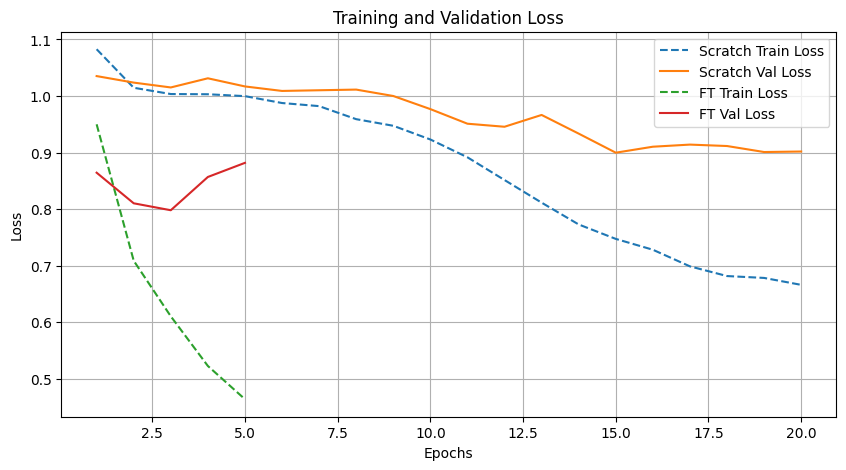

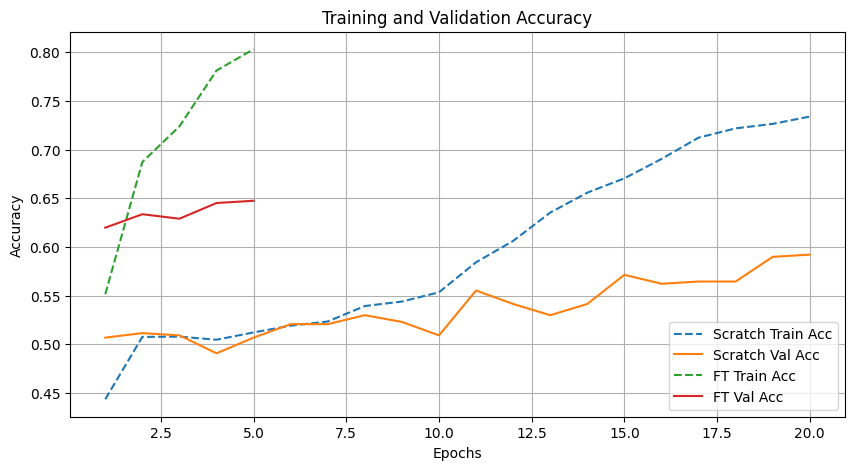

In [11]:
def evaluate_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    start_time = time.time()
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            if hasattr(model, 'config') and hasattr(model.config, 'architectures'):
                 outputs = model(input_ids, attention_mask=attention_mask)
                 logits = outputs.logits
            else:
                 logits, _ = model(input_ids, attention_mask=attention_mask)
            
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    end_time = time.time()
    inference_time = (end_time - start_time) / len(loader.dataset) * 1000 # ms per sample
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return acc, f1, inference_time

acc_scratch, f1_scratch, inf_scratch = evaluate_metrics(scratch_model, test_loader)
acc_ft, f1_ft, inf_ft = evaluate_metrics(ft_model, test_loader)

print("Results:")
print(f"Scratch:    Acc={acc_scratch:.4f}, F1={f1_scratch:.4f}, Inf Time={inf_scratch:.2f}ms, Params={scratch_params}")
print(f"Fine-Tuned: Acc={acc_ft:.4f}, F1={f1_ft:.4f}, Inf Time={inf_ft:.2f}ms, Params={ft_params}")

# Plot Stability / Convergence
print("\nGenerating Stability and Convergence Plots...")
plot_history(history_scratch, history_ft, save_dir="outputs")